In [1]:
import networkx as nx
import dgl
import torch
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
import torch as th
import numpy as np
import scipy.sparse as spp

# Create the same graph from a list of integer pairs.
elist = [(0, 1),(1, 2),(2, 3),(2,6), (3, 4),(4, 5),(6, 7),(7, 8),(8, 6),(8, 9)]
graph_skelton = dgl.DGLGraph(elist)

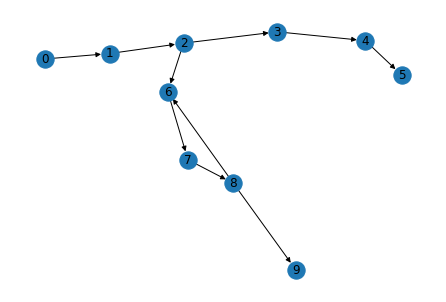

In [4]:
# Visualize the graph.
#graph_skelton.add_edges([9, 0])
nx.draw(graph_skelton.to_networkx(), with_labels=True)
plt.show()

In [5]:
x = th.tensor([10,20,40,20,50,80,70,10,40,20])
graph_skelton.edata['edge_weights'] = x

In [6]:
y = th.tensor([0,0,0,0,0,0,0,0,0,0])
graph_skelton.ndata['pv'] = y

In [127]:
account_balance = th.tensor([20,100,90,40,10,50,30,70,10,30])
graph_skelton.ndata['balance'] = account_balance

In [6]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(0, 1)] = 5

In [5]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(1,2)]

### reverse the graph 

In [7]:
rg =graph_skelton.reverse(share_ndata=True, share_edata=True)

In [12]:
#rg.edata['edge_weights'][rg.edge_id(1, 0)] = 555

In [13]:
#graph_skelton= rg.reverse(share_ndata=True, share_edata=True)

In [14]:
#graph_skelton.edata['edge_weights']

In [15]:
# def pagerank_message_func2(graph):
    
#     list = graph.successors(graph.nodes())
#     sum=0
    
#     for node in graph.nodes():
#         sum=0
        
        
#     for succ in list:
#         sum= sum+ graph.edata['edge_weights'][graph.edge_ids(graph.nodes(), succ)]

#     #out_edge_weights=sum(graph.edata['edge_weights'][graph.edge_ids(graph.nodes(), graph.successors(graph.nodes())) ])
        
#     return {'edge_weights' : graph.edata['edge_weights'] }

### message passing functions

In [16]:
def pagerank_message_func(edges):
    return {'edge_weights' : edges.data['edge_weights'] + edges.src['pv']}

In [18]:
DAMP = 0.8  # damping factor
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['edge_weights'], dim=1)
    pv = DAMP * msgs
    return {'pv' : pv}

In [19]:
# register the above message and reduce function to the reversed graph
rg.register_message_func(pagerank_message_func)
rg.register_reduce_func(pagerank_reduce_func)

In [68]:
# Iterate k times of message passing
K=10
for k in range(K):
    rg.send(rg.edges())
    rg.recv(rg.nodes())
    print(rg.ndata['pv'])

tensor([1690, 1690, 1730,  130,   80,    0, 1610, 1550, 1600,    0])
tensor([1700, 1750, 1800,  130,   80,    0, 1620, 1610, 1670,    0])
tensor([1760, 1820, 1810,  130,   80,    0, 1680, 1680, 1680,    0])
tensor([1830, 1830, 1870,  130,   80,    0, 1750, 1690, 1740,    0])
tensor([1840, 1890, 1940,  130,   80,    0, 1760, 1750, 1810,    0])
tensor([1900, 1960, 1950,  130,   80,    0, 1820, 1820, 1820,    0])
tensor([1970, 1970, 2010,  130,   80,    0, 1890, 1830, 1880,    0])
tensor([1980, 2030, 2080,  130,   80,    0, 1900, 1890, 1950,    0])
tensor([2040, 2100, 2090,  130,   80,    0, 1960, 1960, 1960,    0])
tensor([2110, 2110, 2150,  130,   80,    0, 2030, 1970, 2020,    0])


In [69]:
graph_skelton= rg.reverse(share_ndata=True, share_edata=True)

In [70]:
graph_skelton.ndata['pv']

tensor([2110, 2110, 2150,  130,   80,    0, 2030, 1970, 2020,    0])

### traversing through the graph to find the optimum path

In [120]:
#graph_skelton.nodes( max(graph_skelton.ndata['pv']) )

In [101]:
src, dst, eid = graph_skelton.out_edges(2,'all')

In [126]:
node_path=[]

def choose_next_node(graph, current_node):
    src, dst, eid = graph.out_edges(current_node,'all')
    max_val=0
    for dst_node in dst:
        print(graph.nodes[dst_node].data['pv'])
        if graph.nodes[dst_node].data['pv'] > max_val:
            max_val = graph.nodes[dst_node].data['pv']
            max_node = dst_node

    node_path.append(max_node)

choose_next_node(graph_skelton,2)

tensor([130])
tensor([2030])


In [125]:
# check the other available paths after selecting the most weighted node/edge

def available_other_paths():
    

[tensor(6)]

In [104]:
eid_10 = graph_skelton.edge_id(1,0)
graph_skelton.edges[eid_10].data['edge_weights']

tensor([3])

In [117]:
graph_skelton.edges()[0]

tensor([0, 1, 2, 2, 3, 4, 6, 7, 8, 8])

In [150]:
graph_skelton.nodes()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [142]:
indexx=graph_skelton.successors(2)

In [148]:
eid_10 = graph_skelton.edge_id(2, indexx[1])
graph_skelton.edges[eid_10].data['edge_weights']

tensor([4])